# Non-signal data exercise

In this exercise you take on the role of a senior data analyst correcting mistakes made by a junior analyst. Your consulting company has received the MysteryData data set, and your goal is to build a classifier out of it, and evaluate how well the classifer works. You assigned the job to junior trainee Tux the Linux Penguin (who works for food).

Tux is very excited to work on the data and has produced very promising results. What Tux does not yet know is that MysteryData is actually just random non-signal data where the features x and the class label y are independent of each other - it is not possible to learn anything meaningful from this data. Tux has never taken any of the UTU data analytics courses and has not noticed this. You should help Tux to correct the analyses, so you do not end up reporting incorrect results to your customers.

You will write your answers inside this notebook. If all your answers are correct, your explanations thorough, and you solve the bonus questions, you will get a bonus point. Use written text, code, printouts or visualizations in you answers as needed. Return both this notebook filled (rename it lastname_firstname_studentid.ipynb), as well as a pdf export of the same notebook (same naming, but .pdf instead).

The analysed problem is a binary classification task. We will follow the convention of using +1 to represent the positive class, and -1 the negative. In all but one task we will use area under ROC curve (AUC) to evaluate how well the classifier predicts. For binary classification tasks AUC and c-index are equivalent, 0.5 means random performance and 1.0 perfect predictions. The "true" AUC you would expect to see on a large enough sample of independent test data for any classifier trained on non-signal data is 0.5.

Note that amount of samples, features, and class distribution for MysteryData can differ in different parts of the exercise (these are always written in comments above the code generating the data). Also, in one case there will be a data set on which it is possible to learn better than random classifier.

Some notes on the codes:
- we use predict_proba() instead of predict() when using AUC, because the predicted class probabilities are needed for computing AUC properly (predict() returns only +1/-1 values)
- random seeds are fixed to guarantee that re-running the codes gives same results

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#The data, trust me, you can't learn anything useful from this
def load_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of features
    #positives: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X = rand_state.randn(samples, features)
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    y = rand_state.permutation(y)
    return X, y

# Part 1: some elementary mistakes

## Lesson 1.1: never trust your ----- set performance

The first analysis done by Tux contains an obvious elementary mistake.

In [2]:
#100 samples, 100 features, 50 belong to positive class
X, y = load_mystery_data(100, 100, 50, 2)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


learner = KNeighborsClassifier(n_neighbors=2)
learner.fit(X, y)
#get the estimated probability of belonging to class 1
p = learner.predict_proba(X)[:,1]
auc = roc_auc_score(y, p)
print("I got area under ROC curve %f" % auc)
print('Tux: "I got very high AUC, problem solved!!"')

I got area under ROC curve 0.885600
Tux: "I got very high AUC, problem solved!!"


## Question 1.1
Why can't you trust the AUC result of Tux?


## Write your answer to question 1.1 here:

Tux isn't doing any kind of splitting of the data into test and training sets. Tux is using the same data used to train the model as test data.

## Lesson 1.2: trivial baselines

The second analysis done by Tux is done a bit better, but analysis of results contains another elementary mistake.

In [3]:
#1000 samples, 100 features, 100 belong to positive class
X, y = load_mystery_data(1000, 100, 100, 1)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#Instead of AUC I will use classification accuracy!
from sklearn.metrics import accuracy_score

#Now I use a separate test set!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=1)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
p_test = knn.predict(X_test)
accuracy = accuracy_score(y_test, p_test)
print("Classification accuracy: %f" %accuracy)
print('Tux: "I got 90% classification accuracy, problem solved!!""')
p2 = knn.predict_proba(X_test)[:,1]
auc2 = roc_auc_score(y_test, p2)
print(auc2)

Classification accuracy: 0.900000
Tux: "I got 90% classification accuracy, problem solved!!""
0.5823895520865219


## Question 1.2
1. Does the high classification accuracy really mean that this is a good predictor?
2. Look at the test set predictions in p_test, what has this classifier actually learned?
3. What would the results look like if you used AUC instead of classification accuracy?

## Write your answer to question 1.2 here
1. The high accuracy rate only means that this model is a good predictor for this specific test split because no cross validation is implemented.


2. Because there are only 100 positive labels out of 1000 samples, it seems that the classifier has gotten a 90% score by just classifying all labels as the negative class.


3. The AUC is .5623 which is poor.

# Part 2: introduction to permutation tests

Next, we are using permutation tests to estimate, how likely we are to see AUC values as high as observed, if y is independent of x (non-signal data).

The test is implemented as follows:
- let AUC_original be the AUC obtained in the original analysis
- For 1000 (or preferably more if you have enough CPU time to use) repetitions, shuffle the labels in y, then run the analysis again and compute the AUC value. Store all 1000 AUC values in a list.
- Visualization: visualize the permutation distribution by plotting a histogram of the 1000 AUC values. Does AUC_original look like an outlier, or do you often get as good or better results with permuted class labels?
- p-value: relative fraction of runs, where obtained AUC $\geq$ AUC_original
- example: AUC with original class labeling is 0.6. In 70 runs out of 1000, we obtain as high as or larger AUC. p-value is then $\frac{70}{1000} = 0.07$ 
- result is considered statistically significant, if $p<\alpha$, where $\alpha$ a pre-specified significance level (often $\alpha=0.05$ or $\alpha=0.01$). Statistical significance does not mean that the results are good, only that the classifier has likely learned something from the data. In the following experiments, use $\alpha=0.05$.

## Lesson 2.1: sample size

Tux is now analyzing a small data set with 5-fold cross-validation. 

In [4]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
auc = np.mean(cv_aucs)
print("AUC: %f" %auc)
print('Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"')

AUC: 0.700000
Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"


## Question 2.1
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.

In [5]:
size = 1000
AUC_original = 0.7

auc_perms21 = []
for i in range(size):
    y = np.random.permutation(y)
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc_perms21.append(np.mean(cv_aucs))

The P-Value = 0.103


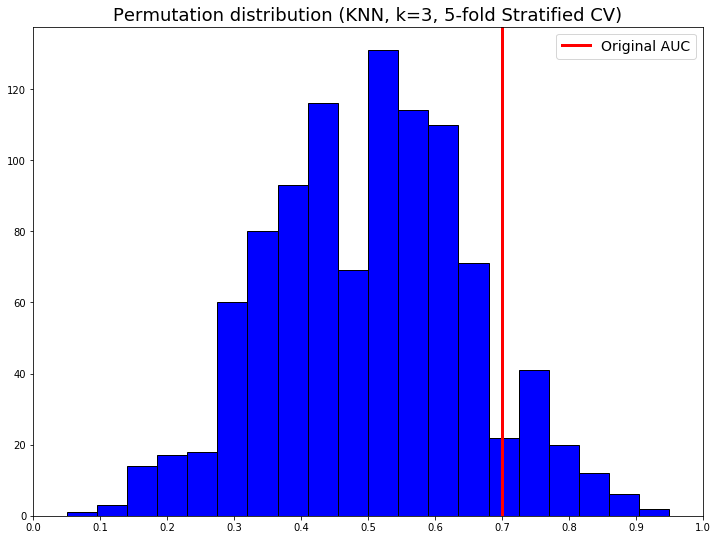

In [6]:
counter = 0
for pauc in auc_perms21:
    if pauc >= AUC_original:
        counter += 1
p_value = counter / size
print("The P-Value =", p_value)

plt.figure(figsize=(12,9))
plt.hist(auc_perms21, 20, color="blue", ec="black")
plt.title("Permutation distribution (KNN, k=3, 5-fold Stratified CV)", fontsize=18)
plt.axvline(AUC_original, color="red", lw=3, label="Original AUC")
plt.xticks(np.arange(0,1.1,.1))
plt.legend(fontsize=14)
plt.show()


Results are not statistically significant with 𝛼=0.05 because P-Value > 𝛼


## Lesson 2.2: sample size again

Let's give poor Tux a better data set that actually has clear difference between the classes and see how things work out. (on this data it is possible to obtain true AUC larger than 0.5)

In [7]:
def load_new_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X_pos = rand_state.randn(positives, features)
    X_neg = rand_state.randn(samples-positives, features)+0.65
    X = np.vstack((X_pos, X_neg))
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    I = rand_state.permutation(samples)
    X = X[I]
    y = y[I]
    return X, y

In [8]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_new_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print("AUC: %f" %cv_auc)
print('Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"')

AUC: 0.875000
Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"


## Question 2.2
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.



In [9]:
AUC_original = 0.875
auc_perms22 = []

for i in range(size):
    y = np.random.permutation(y)
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc_perms22.append(np.mean(cv_aucs))

p-value is 0.003


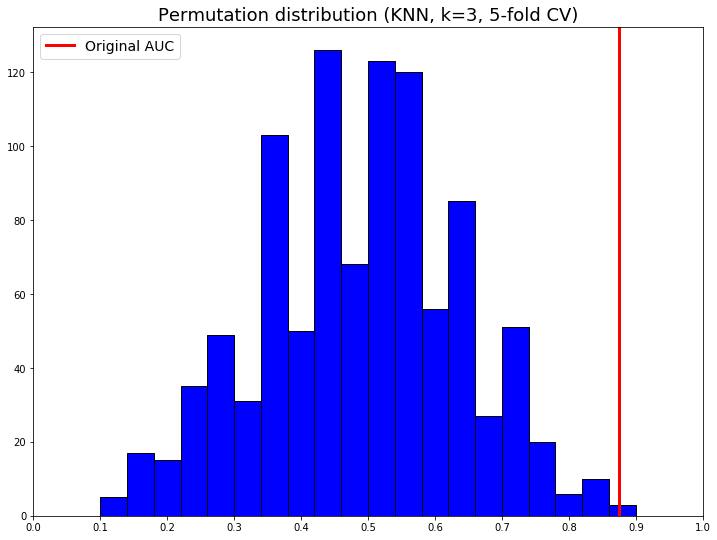

In [10]:
counter = 0
for pauc in auc_perms22:
    if pauc >= AUC_original:
        counter += 1
p_value = counter / size
print("p-value is", p_value)

plt.figure(figsize=(12,9))
plt.hist(auc_perms22, 20, color="blue", ec="black")
plt.title("Permutation distribution (KNN, k=3, 5-fold CV)", fontsize=18)
plt.xticks(np.arange(0,1.1,.1))
plt.axvline(AUC_original, color="red", lw=3, label="Original AUC")
plt.legend(fontsize=14)
plt.show()


1. Yes these results are significant with a p-value of 0.003 < 0.05

2. we can reject the null hypothesis with signiﬁcance level α

3. Strong evidence that the classiﬁer learned from the data


# Part 3: mis-using feature selection

Here is a very simple correlation based feature selection method

In [11]:
from scipy.stats import kendalltau

def select(X, Y, scount):
    #select scount features from X with highest correlation with Y
    correlations = []
    for i in range(X.shape[1]):
        corr = kendalltau(X[:,i], Y)[0]
        correlations.append(np.abs(corr))
    correlations = np.array(correlations)
    I = np.argsort(correlations)
    I = I[::-1]
    return I[:scount]

In [12]:
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC before feature selection is %f"' %cv_auc)


#I'm going to improve my AUC with feature selection!!!
I = select(X, y, 5)
X_fs = X[:,I]
cv_aucs = []
for train, test in cv.split(X_fs, y):
    X_train = X_fs[train]
    y_train = y[train]
    X_test = X_fs[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC after feature selection is %f, it really works!!"' %cv_auc)

Tux: "My CV-AUC before feature selection is 0.496000"
Tux: "My CV-AUC after feature selection is 0.808000, it really works!!"


## Question 3.1

It is possible to implement a permutation test for the (incorrect) combination of feature selection and cross-validation Tux has implemented here. Simply run the flawed analysis for 1000 random permutations of y. 

Use permutation test to show Tux that the feature selection based classification approach is actually not learning anything from the data ($\alpha=0.05$, provide both visualization of the permutation distribution, as well as the p-value). Running the test may take a while. Analyse what is going on here, why did the results look so good?

In [14]:
AUC_original = 0.808
auc_perms31 = []
size=1000
for i in range(size):
    y = np.random.permutation(y)
    I = select(X, y, 5)
    X_fs = X[:,I]
    cv_aucs = []
    for train, test in cv.split(X_fs, y):
        X_train = X_fs[train]
        y_train = y[train]
        X_test = X_fs[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc_perms31.append(np.mean(cv_aucs))

p-value is 0.651


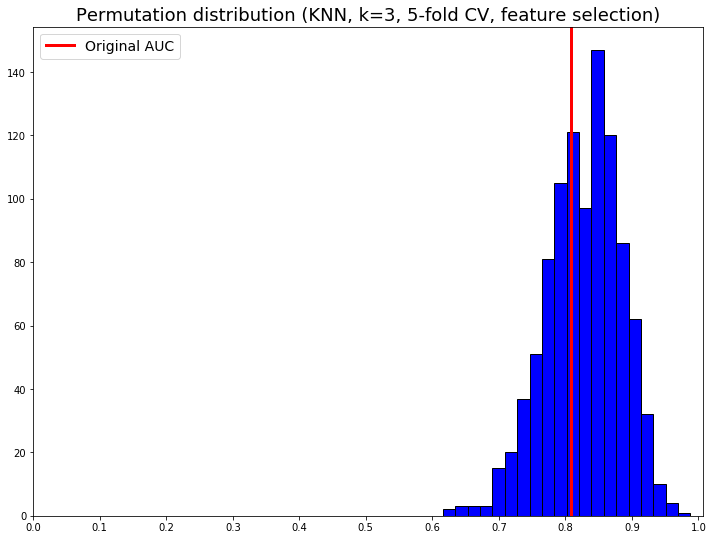

In [15]:
AUC_original = 0.808
counter = 0
for pauc in auc_perms31:
    if pauc >= AUC_original:
        counter += 1
p_value = counter / size
print("p-value is", p_value)

plt.figure(figsize=(12,9))
plt.hist(auc_perms31, 20, color="blue", ec="black")
plt.title("Permutation distribution (KNN, k=3, 5-fold CV, feature selection)", fontsize=18)
plt.axvline(AUC_original, color="red", lw=3, label="Original AUC")
plt.xticks(np.arange(0,1.1,.1))
plt.legend(fontsize=14)
plt.show()


P value greater than 0.05 so no nothing has been learned in this model

## Question 3.2 (bonus exercise)

Correct the bias in above example by combining feature selection properly with cross-validation, run the experiment again. Do also a permutation test for this experiment with as many permutations as you can afford in a reasonable amount of time.

In [16]:
cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    I = select(X, y, 5)
    X_fs= X[:,I]
    X_train = X_fs[train]
    y_train = y[train]
    X_test = X_fs[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)

print(cv_auc)
### doing 350 permutations because it was taking so long to finish running
auc_perms32 = []
for i in range(350):
    y = np.random.permutation(y)
    cv_aucs = []
    for train, test in cv.split(X, y):
        I = select(X, y, 5)
        X_fs= X[:,I]
        X_train = X_fs[train]
        y_train = y[train]
        X_test = X_fs[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc_perms32.append(np.mean(cv_aucs))

0.78


In [17]:
print ("CV score = 0.78")

CV score = 0.78


p-value is 0.237


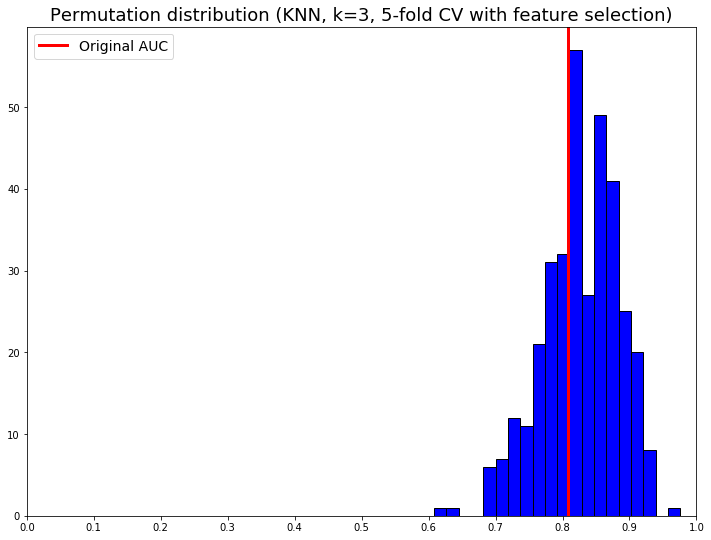

In [21]:
counter = 0
for pauc in auc_perms32:
    if pauc >= AUC_original:
        counter += 1
p_value = counter / size
print("p-value is", p_value)


plt.figure(figsize=(12,9))
plt.hist(auc_perms32, 20, color="blue", ec="black")
plt.xticks(np.arange(0,1.1,.1))
plt.title("Permutation distribution (KNN, k=3, 5-fold CV with feature selection)", fontsize=18)
plt.axvline(AUC_original, color="red", lw=3, label="Original AUC")
plt.xticks(np.arange(0,1.1,.1))
plt.legend(fontsize=14)
plt.show()

